# Example Notebook - Model Training + Example Trades

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
import optuna

Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/example_notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from code_utils.preprocessing import load_auction_data, load_forecasts,preprocess_data
from code_utils.feature_engineering import make_new_price_indicators, generate_lag_timeseries, generate_close_timeseries
from code_utils.training import timeseries_train_test_split, plot_model_validation, plot_roc_curve, objective

## Preprocessing

load and preprocess auction data

In [909]:
auction_data, _ = load_auction_data(['../data/raw/auction_data.csv', '../data/raw/system_prices.csv'])
auction_data = preprocess_data(auction_data)

# define spreads and spread directions binary labels
auction_data.loc[:,'auction_price_spread']=auction_data['price_second_auction']-auction_data['price_first_auction']
auction_data.loc[:,'system_price_spread']=auction_data['system_price']-auction_data['price_first_auction']
auction_data['auction_spread_dir']=(auction_data['auction_price_spread']>0).astype(int)
auction_data['system_spread_dir']=(auction_data['system_price_spread']>0).astype(int)

load and preprocess signals (i.e. pre-made forecasts of energy fundamentals)

In [910]:
fundamentals =load_forecasts('../data/raw/forecast_features.csv')
fundamentals=preprocess_data(fundamentals)
# drop derived features
fundamentals = fundamentals.drop(columns=['availability', 'within_day_availability', 'long_term_wind_over_demand', 'long_term_wind_over_margin',
       'long_term_solar_over_demand', 'long_term_solar_over_margin','margin_over_demand'])

make indicators

In [ ]:
signals=auction_data.columns

# lag timeseries 24hr, 72hr, weekly
data=generate_lag_timeseries(auction_data, signals, 24)
data=generate_lag_timeseries(auction_data, signals, 72)
data=generate_lag_timeseries(auction_data, signals, 24*7)
# close timeseries i.e. the last available (closing) price from prevous day
data=generate_close_timeseries(auction_data, signals)

# indicator_methods=[
#               #      ('ATR_24', 'calculate_ATR', {'window': 24, 'lag': 24}),
#               #      ('ATR_7', 'calculate_ATR', {'window': 24, 'lag': 7*24}),
#               #      ('RSTDEV_24', 'calculate_RSTDEV', {'window': 24}),
#               #      ('RSTDEV_7', 'calculate_RSTDEV', {'window': 7*24}),
#               #      ('ZSCORE_24', 'calculate_ZSCORE', {'window': 24}),
#               #      ('ZSCORE_7', 'calculate_ZSCORE', {'window': 7*24}),
#               #      ('ADX_24', 'calculate_ADX', {'window': 24}),
#               #      ('ADX_7', 'calculate_ADX', {'window': 7*24}),
#               #      ('RSI_24', 'calculate_RSI', {'window': 24}),
#               #      ('RSI_7', 'calculate_RSI', {'window': 7*24}),
#               #      ('MOM_3h', 'calculate_MOM', {'lag':3}),
#               #      ('MOM_6h', 'calculate_MOM', {'lag':6}),
# ]
                      
# timeseries=['auction_price_spread_lag24','price_first_auction_lag24','price_second_auction_lag24'
                # 'traded_volume_first_auction_lag24','traded_volume_second_auction_lag24']          


# data=make_new_price_indicators(auction_data, timeseries, indicator_methods)

Scale data and create validation folds

In [913]:
data=pd.concat([data, fundamentals], axis=1)
data=data.dropna(axis=0, how='any')
# keep the second helf of the data as most relevant to the 'current/future' market conditions (i.e. those at the end of the dataset which we regard as unseen)
data=data.iloc[int(data.shape[0]/2):]

# the target is the auction spread direction i.e. positive or negative spread between the two day ahread auction prices
y=data[['auction_spread_dir']]

# drop all future (i.e. not lagged) columns from features
X=data.drop(columns=['auction_spread_dir',
                     'system_spread_dir', 
                     'price_second_auction', 
                     'system_price', 
                     'traded_volume_second_auction', 
                     'auction_price_spread',
                     'system_price_spread'])

# scale data with a standard scaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

holdout_index=int(9*X_scaled.shape[0]/10) # 90% of data for training, 10% for holdout validation (i.e. uneeen data)

X_holdout = X_scaled.iloc[holdout_index:]
y_holdout = y.iloc[holdout_index:]

cv_folds=timeseries_train_test_split(X_scaled.iloc[:holdout_index], y.iloc[:holdout_index], 9)

## Auction Forecaster Model Training

### Logistic Regression

In [821]:
model_config_lr={'penalty':'l2',
                 'C':1.0,
                 'max_iter':1000}

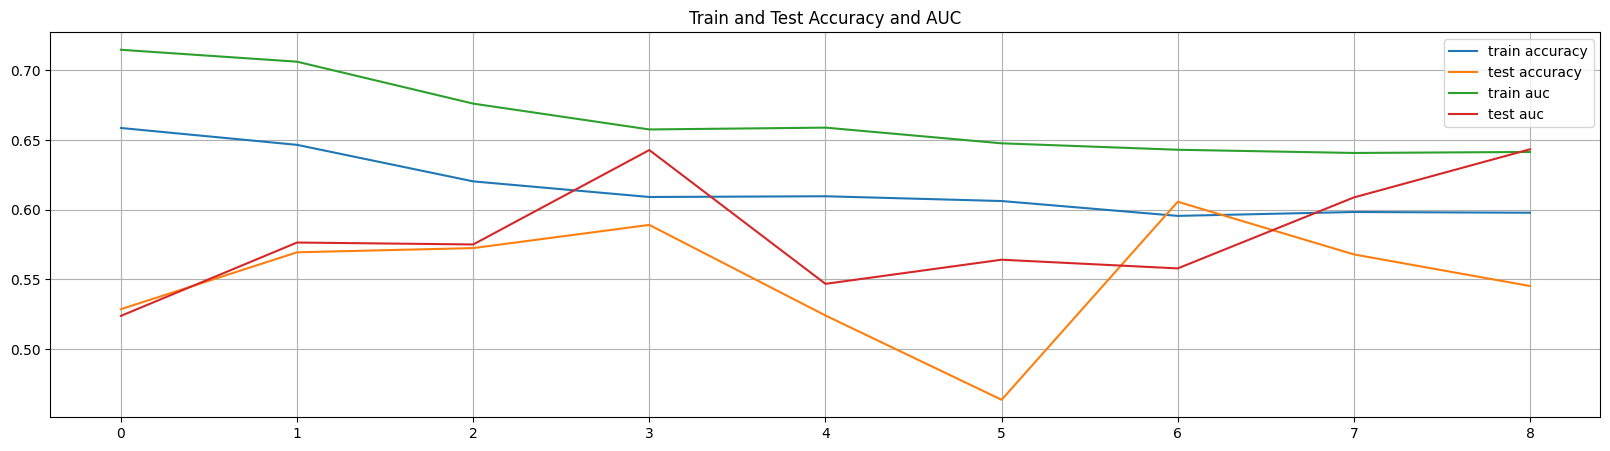

In [822]:
log_reg = LogisticRegression(**model_config_lr)
plot_model_validation(cv_folds, log_reg)


The model is not overfitting. Training accuracy decreases as the training dataset is made larger (model is not memorising the larger datasets). But test accuracy only slightly increases, so the model is only slighty able to generalise better given more data.

For the final fold the model accuracies are the same on the test dataset and the train dataset.

The lack of improvement as more training data is added is likely due to the simplicity of the model. 

We look at the accuracy and ROC for the final fold model (which is the best guess model we take forward)

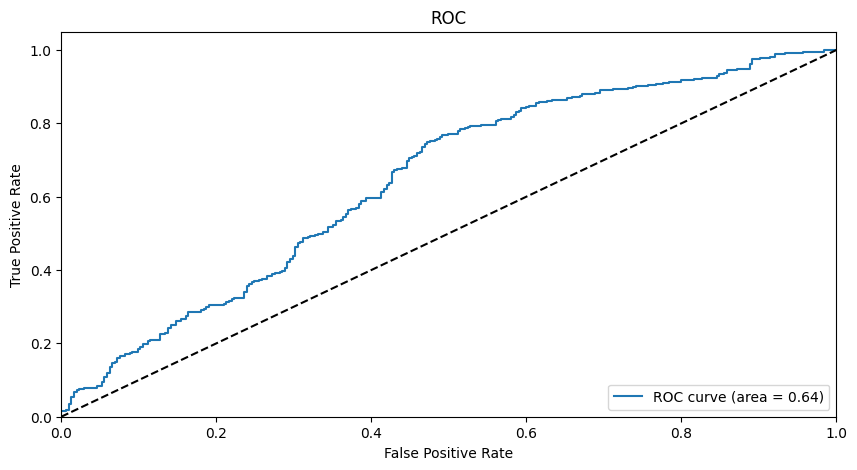

Best threshold: 0.4113078284427804
Threshold = 0.4113078284427804. Accuracy: 0.6450151057401813


In [823]:
(X_train, y_train, X_test, y_test) = cv_folds[-1]
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train['auction_spread_dir'])
y_pred_proba_LR = log_reg.predict_proba(X_test)[:, 1]

# plot the ROC curve
roc_auc, fpr, tpr, thresholds = plot_roc_curve(y_test, y_pred_proba_LR)

# use the Youden's J statistic to pick the best threshold

j_scores = tpr - fpr
best_thresh_LR = thresholds[j_scores.argmax()]
print(f'Best threshold: {best_thresh_LR}')
y_pred_LR = (y_pred_proba_LR > best_thresh_LR).astype(int)
print(f'Threshold = {best_thresh_LR}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_LR)}')

We look at feature importance from Logistic Regression to see which features influence the predictions

In [824]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': log_reg.coef_[0]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                                Feature  Importance
44                          stack_price    0.362491
41                       long_term_wind    0.360228
43                        snsp_forecast    0.339750
38                               demand    0.223770
46                     inertia_forecast    0.159586
34           auction_price_spread_close    0.156459
40                    within_day_margin    0.143550
32   traded_volume_second_auction_close    0.132164
36             auction_spread_dir_close    0.126483
42                      long_term_solar    0.103269
4     traded_volume_first_auction_lag24    0.076517
37              system_spread_dir_close    0.074420
45     within_day_potential_stack_price    0.062261
10              system_spread_dir_lag24    0.060834
27            auction_spread_dir_lag168    0.060156
23  traded_volume_second_auction_lag168    0.057228
35            system_price_spread_close    0.050934
16           auction_price_spread_lag72    0.045001
9           

### XGBoost classifier (tuned with Optuna)

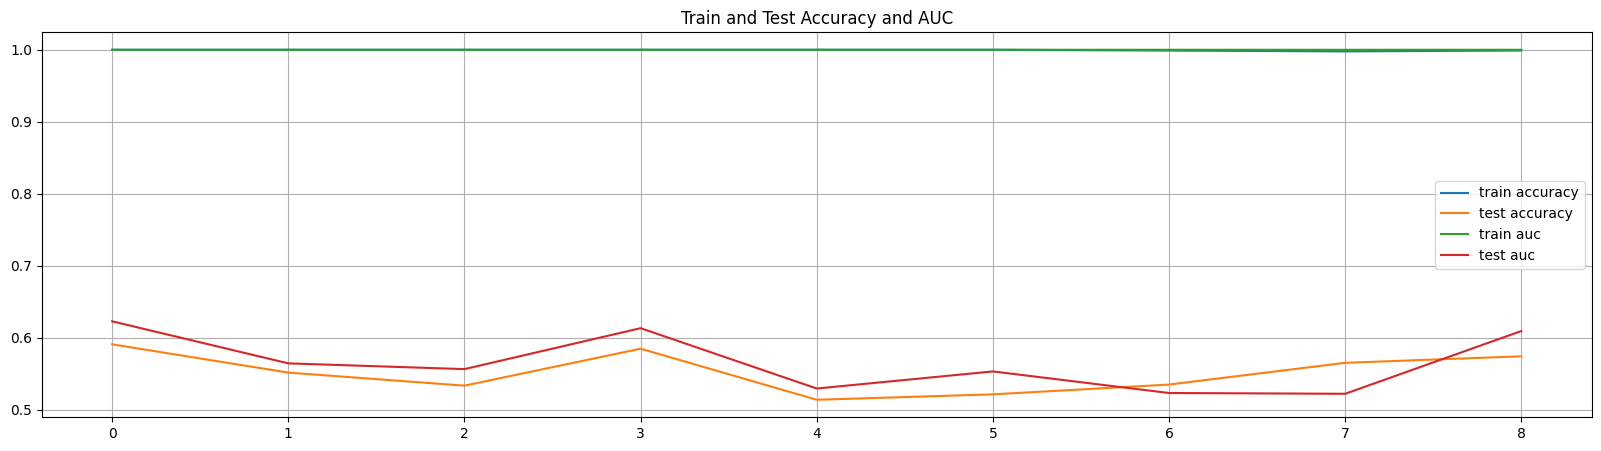

In [825]:
xgb_clf = XGBClassifier()
plot_model_validation(cv_folds, xgb_clf)

the out-the-box XGB model overfits! The train accuracy stays high even as more train data is added, way higher than test accuracy which doesnt improve. So we regularise!

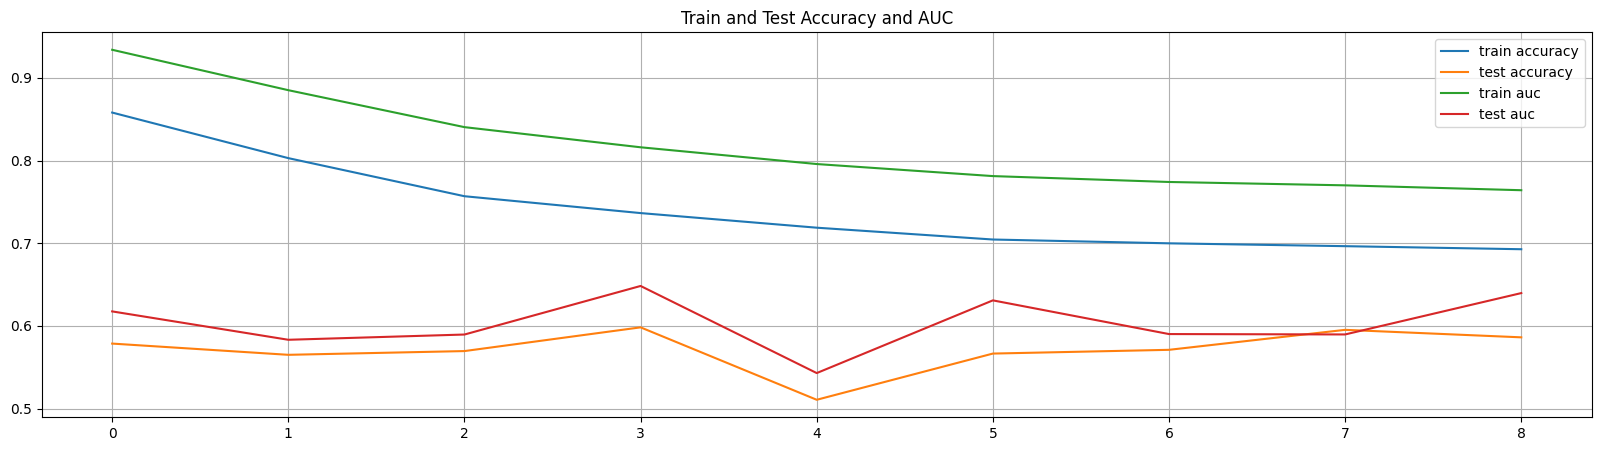

In [826]:
model_config_xgb={'learning_rate' :0.005,  # slower learning rate
                            'n_estimators':3000,   # increase since learning is slower
                            'max_depth': 2, # simple trees
                            'min_child_weight': 2, 
                            'gamma': 0.1, 
                            'subsample': 0.5, # randomly sample 50% of the data to regularise fitting
                            'colsample_bytree': 0.5, # randomly sample 50% of the data to regularise fitting
                            'reg_alpha': 0.5, # regularise param
                            'reg_lambda': 5} # regularise param
xgb_clf = XGBClassifier(**model_config_xgb)
plot_model_validation(cv_folds, xgb_clf)

again we see not much improvement as data is added. The model does not improve much as data is added or rather the model is forgetful or doesnt finduseful trends from data far in the past. This could be becuase they are not useful or a limitation of the model.

In [827]:
# use optuna to fin best params for XGBoost classifier
study = optuna.create_study(direction="maximize")
new_objective = lambda x: objective(cv_fold=cv_folds[-1], score='accuracy', trial=x)
study.optimize(new_objective, n_trials=50)
print("Best trial:", study.best_trial.params)


[I 2025-05-29 16:20:15,214] A new study created in memory with name: no-name-bcb9f224-3054-4c7c-9321-22dae63995b4


[I 2025-05-29 16:20:16,702] Trial 0 finished with value: 0.6163141993957704 and parameters: {'learning_rate': 0.006151291589583832, 'n_estimators': 2046, 'max_depth': 2, 'min_child_weight': 4, 'gamma': 0.18523988806388236, 'subsample': 0.615038943697199, 'colsample_bytree': 0.5849888887712115, 'reg_alpha': 0.49005938864268006, 'reg_lambda': 4.978624620304326}. Best is trial 0 with value: 0.6163141993957704.
[I 2025-05-29 16:20:17,781] Trial 1 finished with value: 0.622356495468278 and parameters: {'learning_rate': 0.0014700528757085217, 'n_estimators': 1932, 'max_depth': 2, 'min_child_weight': 3, 'gamma': 0.27586208271657736, 'subsample': 0.5931113993476762, 'colsample_bytree': 0.5649826073584601, 'reg_alpha': 0.6236950511235344, 'reg_lambda': 2.8572651406180003}. Best is trial 1 with value: 0.622356495468278.
[I 2025-05-29 16:20:20,013] Trial 2 finished with value: 0.6027190332326284 and parameters: {'learning_rate': 0.004885743203586736, 'n_estimators': 2045, 'max_depth': 4, 'min_chi

Best trial: {'learning_rate': 0.0010379285121370155, 'n_estimators': 2351, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.23827657359841373, 'subsample': 0.5602029535091642, 'colsample_bytree': 0.6699648350010676, 'reg_alpha': 0.30652381056990213, 'reg_lambda': 3.5613757799294055}


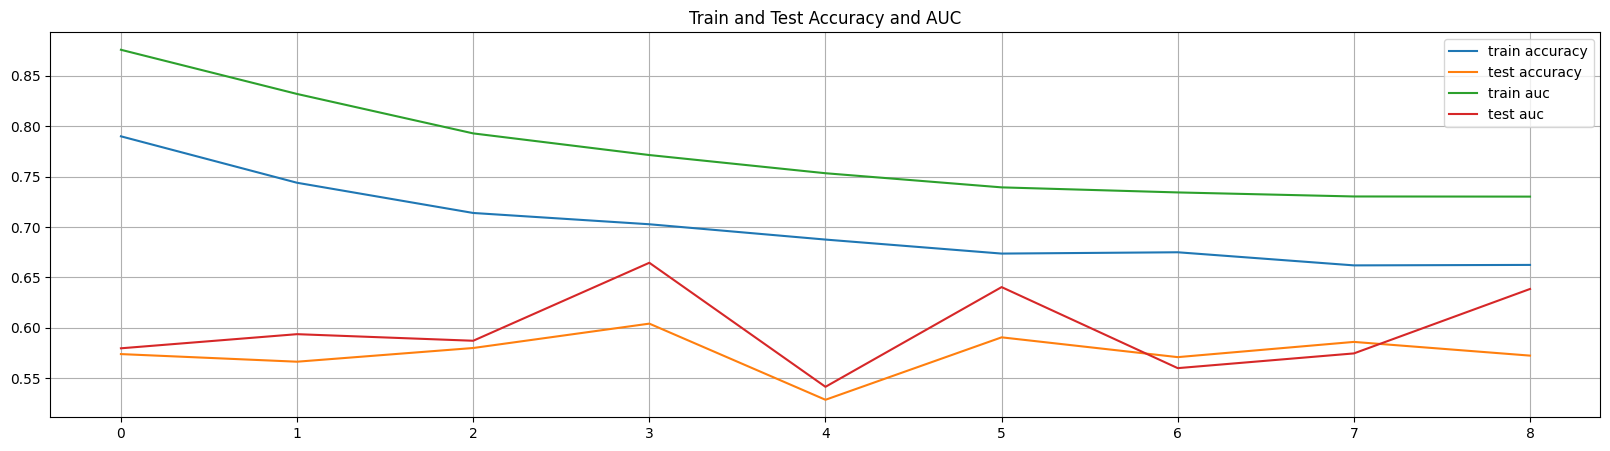

In [915]:
xgb_clf = XGBClassifier(**study.best_trial.params)
plot_model_validation(cv_folds, xgb_clf)

not overfitting with best params! Still not much improvement tho.

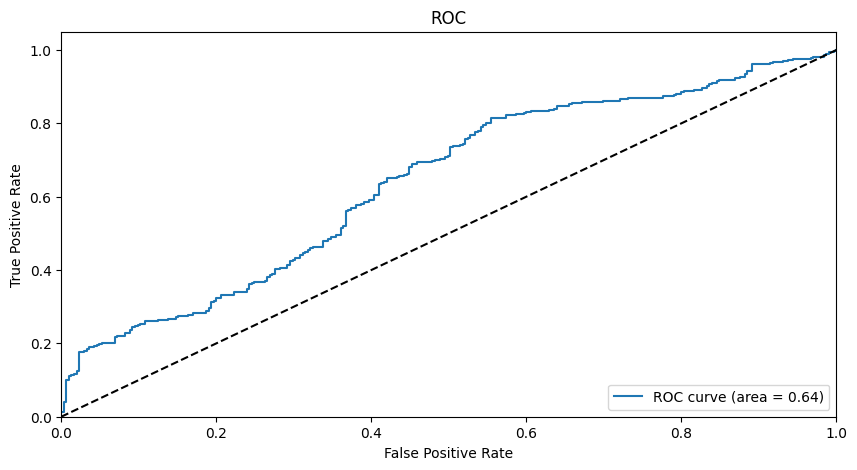

Best threshold: 0.4471627175807953
Threshold = 0.4471627175807953. Accuracy: 0.6450151057401813


In [916]:
(X_train, y_train, X_test, y_test) = cv_folds[-1]
xgb_clf.fit(X_train, y_train['auction_spread_dir'])
y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]

roc_auc, fpr, tpr, thresholds = plot_roc_curve(y_test, y_pred_proba_XGB)

# use the Youden's J statistic to pick the best threshold

j_scores = tpr - fpr
best_thresh_XGB = thresholds[j_scores.argmax()]
print(f'Best threshold: {best_thresh_XGB}')
y_pred_XGB = (y_pred_proba_XGB > best_thresh_XGB).astype(int)
print(f'Threshold = {best_thresh_XGB}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_LR)}')

Get feature importance from XGBoost

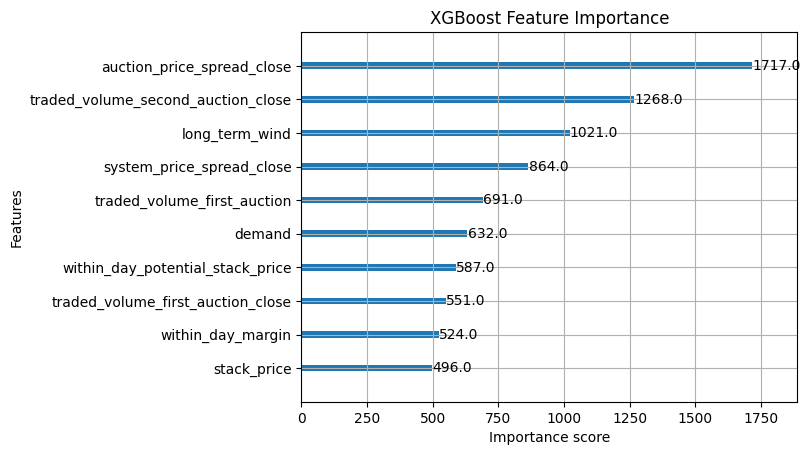

In [917]:
xgb_importance = xgb_clf.get_booster().get_score(importance_type='weight')
xgb_importance_df = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Importance': list(xgb_importance.values())
}).sort_values(by='Importance', ascending=False)

xgb.plot_importance(xgb_clf, importance_type='weight', max_num_features=10, title='XGBoost Feature Importance')
plt.show()

### ensemble model

Overall class balance is 51-49 so close to even. However the final test set is not as balanced, this will impact the best threshold we have chosen since class imbalances impact the threshold we chose for predicting classes. 

In [918]:
print(f"Overall class balance: {data['auction_spread_dir'].value_counts(normalize=True)}")
print(f"Train class balance: {y_train['auction_spread_dir'].value_counts(normalize=True)}")
print(f"Test class balance: {y_test['auction_spread_dir'].value_counts(normalize=True)}")

Overall class balance: auction_spread_dir
0    0.525014
1    0.474986
Name: proportion, dtype: float64
Train class balance: auction_spread_dir
0    0.536925
1    0.463075
Name: proportion, dtype: float64
Test class balance: auction_spread_dir
1    0.539275
0    0.460725
Name: proportion, dtype: float64


We try an ensemble model by taking the average probability predicted from the Logistic Regression and XGBoost Classifier models

In [919]:
ensemble_weights=[0.3, 0.7]
y_pred_proba_ens=(ensemble_weights[0]*y_pred_proba_LR + ensemble_weights[1]*y_pred_proba_XGB)/(ensemble_weights[0]+ensemble_weights[1])

In [920]:
print(f"mean {y_pred_proba_ens.mean()}")
print(f"median {np.median(y_pred_proba_ens)}")

mean 0.4816297395851533
median 0.47933966340270007


the mean probability is less than 0.5. Suggesting the model slightly 'expects' negative spreads more than positive even tho the dataset is balanced or unbalanced towards positive spreads (test dataset). In reality the probability output is not always a reliably scaled probability and can be biased. It only serves to allocate higher probs towards one target and lower towards another. Rather the model gives its optimised target predicitons ONLY when paired with a threshold which can be chosen independently. This threshold should be close to the mean to give the most accurate predictions on both classes (i.e. best predictions assuming that the targets themeselves are of equal importance).

So our model exhibits bias towards negative spreads but this bias can be ammeliorated with a good threshold around 0.46

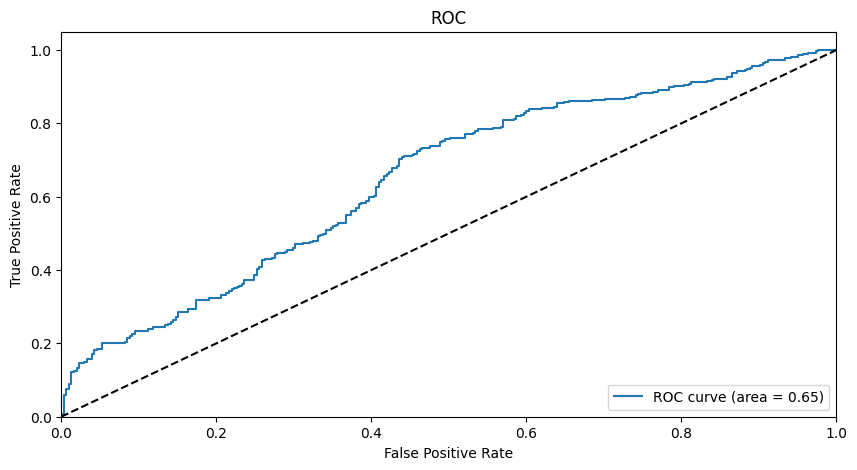

Best threshold: 0.45848384763739924
Threshold = 0.45848384763739924. Accuracy: 0.6389728096676737


In [921]:
roc_auc, fpr, tpr, thresholds = plot_roc_curve(y_test, y_pred_proba_ens)

j_scores = tpr - fpr
best_thresh_roc = thresholds[j_scores.argmax()]
print(f'Best threshold: {best_thresh_roc}')

y_pred_ens = (y_pred_proba_ens > best_thresh_roc).astype(int)
print(f'Threshold = {best_thresh_roc}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_ens)}')

We have used the Youden's J statistic to pick the best threshold. This is the threshold that maximises the difference between the true positive rate and the false positive rate.

The threshold for prediction is at 0.41 close to the mean! So less than 0.5. This is expected the model is biased in probability but this bias can be handled ad hoc by setting the threshold for target prdicition at roughly the mean.

We are actually intetested most in accuracy since our dataset is balanced and there is no distinction between positive and negative spread.

In [922]:
accuracies = []
thresholds_acc = np.linspace(0, 1, 200)

for thresh in thresholds_acc:
    y_pred_ens_acc = (y_pred_proba_ens >= thresh).astype(int)
    acc = accuracy_score(y_test['auction_spread_dir'], y_pred_ens_acc)
    accuracies.append(acc)

best_thresh_acc = thresholds_acc[np.argmax(accuracies)]
best_acc = accuracies[np.argmax(accuracies)]
print(f"Best threshold: {best_thresh_acc}, Best accuracy: {best_acc}")

y_pred_ens_acc = (y_pred_proba_ens > best_thresh_acc).astype(int)

Best threshold: 0.45226130653266333, Best accuracy: 0.6404833836858006


same threshold of 0.41 to 2 dp.

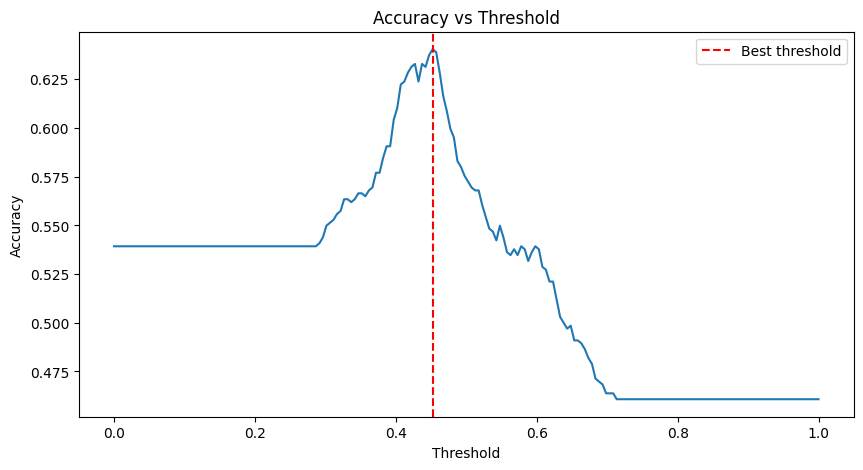

In [923]:
# plot the accuracy vs threshold
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, 200), accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.axvline(x=best_thresh_acc, color='r', linestyle='--', label='Best threshold')
plt.legend()
plt.show()

## When does the model guess correctly? I.e. When should we trade?

The best performing threshold on the test set should lead to predictions with roughly the same class balance as the test set

In [896]:
y_pred_ens_acc.sum()/y_pred_ens_acc.shape[0]

np.float64(0.6178247734138973)

on the entire dataset this balance may be different. I.e. the threshold should also be continuously validated going forward.

We now investigate when to trade. We have a long position i.e. buy in first auction to sell in second, or a short trade sell to buy or no trade. We investigate these options by having predictions for class 0 and class 1 at different thresholds and having a no prediction option in between them.

* Class 0 = negative spread = long position
* class 1 = positive spread = short position
* no prediction = no trade

On the test dataset the correctness of the predicitons is quite evenly distributed (both temporally and across sizes of spread) see below

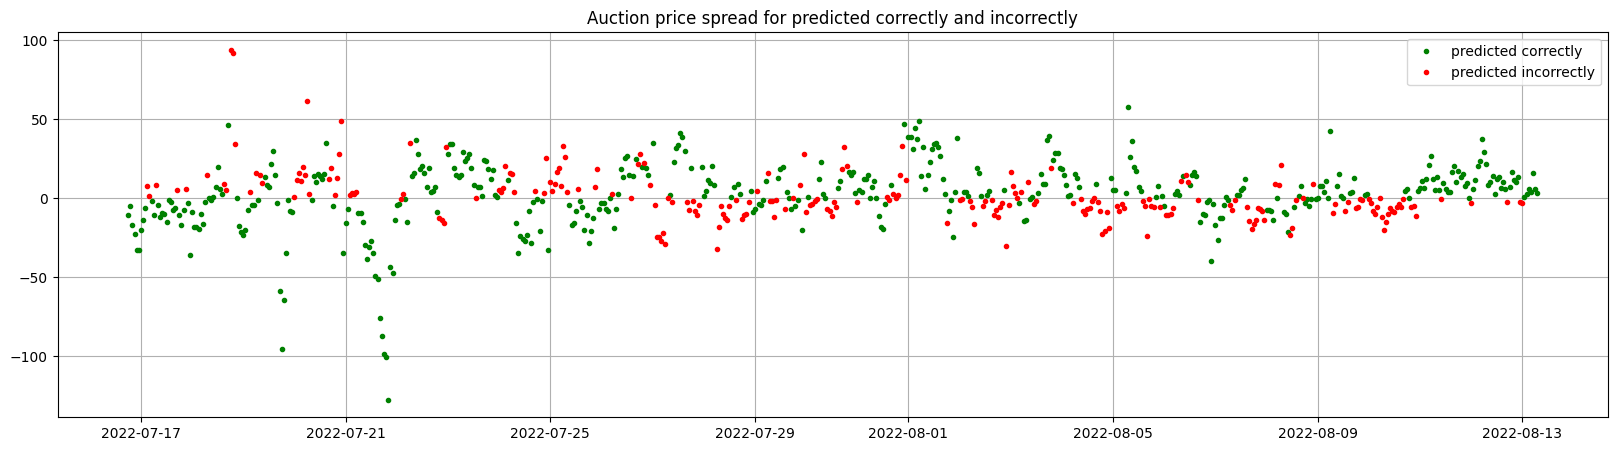

In [897]:
# bar plot the auction spread sperated according to whether the direction of the spread was predicted correctly or not
pred_correctornot = y_test['auction_spread_dir'] == y_pred_ens_acc

spreads=data.loc[y_test.index, 'auction_price_spread']

correct_spreads=spreads[pred_correctornot]
incorrect_spreads=spreads[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than
plt.plot(correct_spreads, label='predicted correctly', linestyle='None', marker='o', markersize=3, color='green')
plt.plot(incorrect_spreads, label='predicted incorrectly', linestyle='None', marker='o', markersize=3, color='red')
plt.legend(loc='best')
plt.title('Auction price spread for predicted correctly and incorrectly')
plt.show()

plot the model probabilities highlighted according to whether the direction of the spread was predicted correctly or not


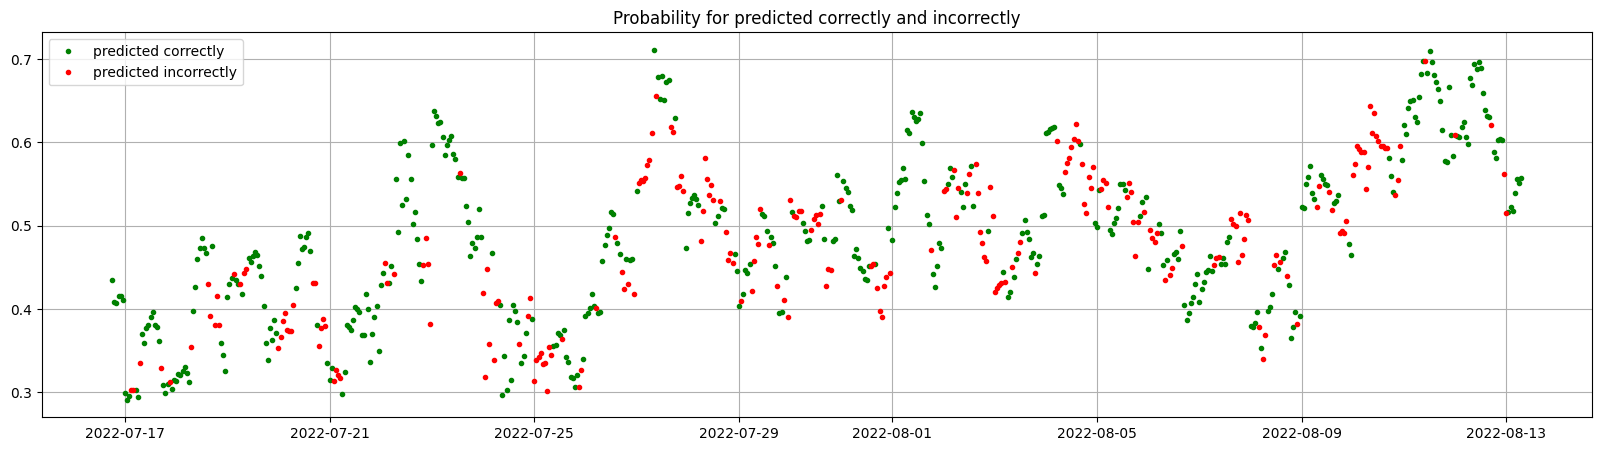

In [898]:
y_pred_proba_df=pd.DataFrame(y_pred_proba_ens, columns=['predicted_prob'], index=y_test.index)

prob_when_correct=y_pred_proba_df[pred_correctornot]
prob_when_incorrect=y_pred_proba_df[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than 
plt.plot(prob_when_correct, label='predicted correctly', linestyle='None', marker='o', markersize=3, color='green')
plt.plot(prob_when_incorrect, label='predicted incorrectly', linestyle='None', marker='o', markersize=3, color='red')
plt.legend(loc='best')
plt.title('Probability for predicted correctly and incorrectly')
plt.show()

We observe the expected trend that when probabilities are extreme then the model is more confident and tends to make a better prediction!

Select periods where predicted probability is high or low (plus/minus 1 stdev for example). This pickiness impacts the number of trades made but increase the accuracy of the predicitonos and hence the success of the trades.


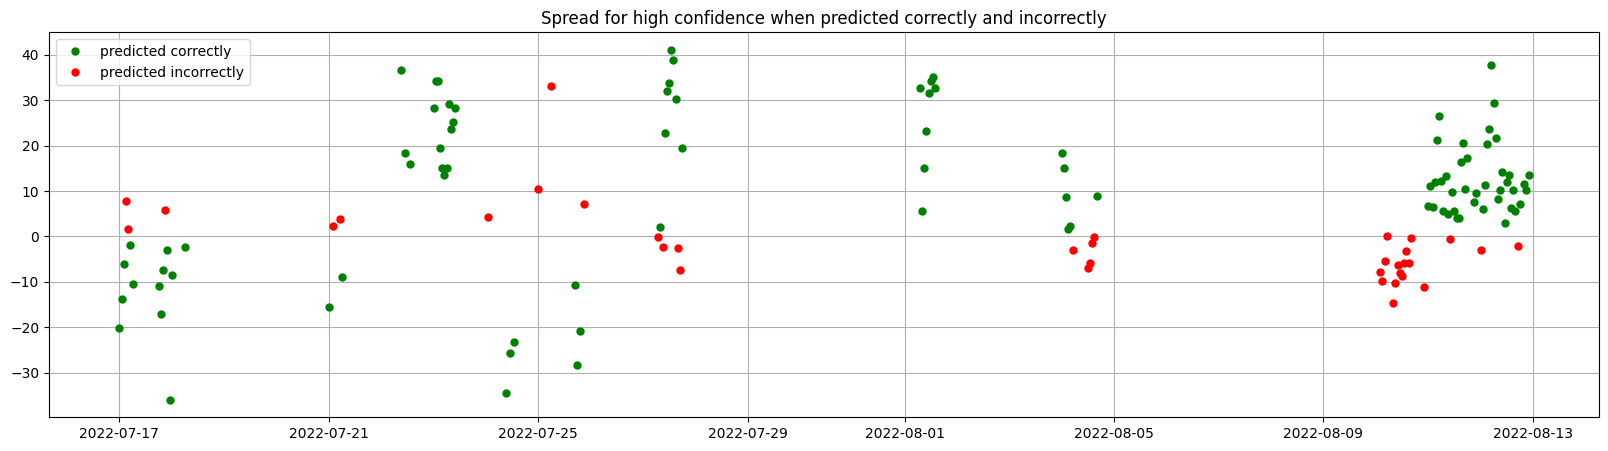

In [899]:
pickiness = 1.4

thresh_high_proba=best_thresh_acc+pickiness*y_pred_proba_df['predicted_prob'].std()
thresh_low_proba=best_thresh_acc-pickiness*y_pred_proba_df['predicted_prob'].std()

spread_high_proba = spreads[(y_pred_proba_df['predicted_prob'] > thresh_high_proba) | (y_pred_proba_df['predicted_prob'] < thresh_low_proba)]

spread_high_proba_when_correct=spread_high_proba[pred_correctornot]
spread_high_proba_when_incorrect=spread_high_proba[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than 
plt.plot(spread_high_proba_when_correct, label='predicted correctly', linestyle='None', marker='o', markersize=5, color='green')
plt.plot(spread_high_proba_when_incorrect, label='predicted incorrectly', linestyle='None', marker='o', markersize=5, color='red')
plt.legend(loc='best')
plt.title('Spread for high confidence when predicted correctly and incorrectly')
plt.show()

In [900]:
pred_correctornot[(y_pred_proba_df['predicted_prob'] > thresh_high_proba) | (y_pred_proba_df['predicted_prob'] < thresh_low_proba)].value_counts(normalize=True)

auction_spread_dir
True     0.732824
False    0.267176
Name: proportion, dtype: float64

accuracy of the picky predcitions is now 0.73!

In [901]:
print(f"Number of trades: {len(spread_high_proba)}")
print(f"Proportion of periods with trades: {len(spread_high_proba)/len(y_test)}")

Number of trades: 131
Proportion of periods with trades: 0.19788519637462235


## Performance on Unseen Data

In [902]:
unseen_pred_proba_LR = log_reg.predict_proba(X_holdout[X_test.columns])[:, 1]
unseen_pred_proba_XGB = xgb_clf.predict_proba(X_holdout[X_test.columns])[:, 1]
unseen_pred_proba_ens = (ensemble_weights[0]*unseen_pred_proba_LR + ensemble_weights[1]* unseen_pred_proba_XGB) / (ensemble_weights[0]+ensemble_weights[1])

In [903]:
unseen_accuracies = []
unseen_thresholds_acc = np.linspace(0, 1, 200)

for thresh in unseen_thresholds_acc:
    unseen_pred_ens_acc = (unseen_pred_proba_ens >= thresh).astype(int)
    acc = accuracy_score(y_holdout['auction_spread_dir'], unseen_pred_ens_acc)
    unseen_accuracies.append(acc)

unseen_best_thresh_acc = unseen_thresholds_acc[np.argmax(unseen_accuracies)]
unseen_best_acc = unseen_accuracies[np.argmax(unseen_accuracies)]
print(f"Best threshold: {unseen_best_thresh_acc}, Best accuracy: {unseen_best_acc}")

Best threshold: 0.5276381909547738, Best accuracy: 0.65625


In [904]:
# the data is unseen so we use the best threshold found on the test set

unseen_pred_ens_acc = (unseen_pred_proba_ens > best_thresh_acc).astype(int)
print(f'Accuracy: {accuracy_score(y_holdout["auction_spread_dir"], unseen_pred_ens_acc)}')

Accuracy: 0.6277173913043478


accuracy has taken a hit when the model is used on unseen data as expected. Model 

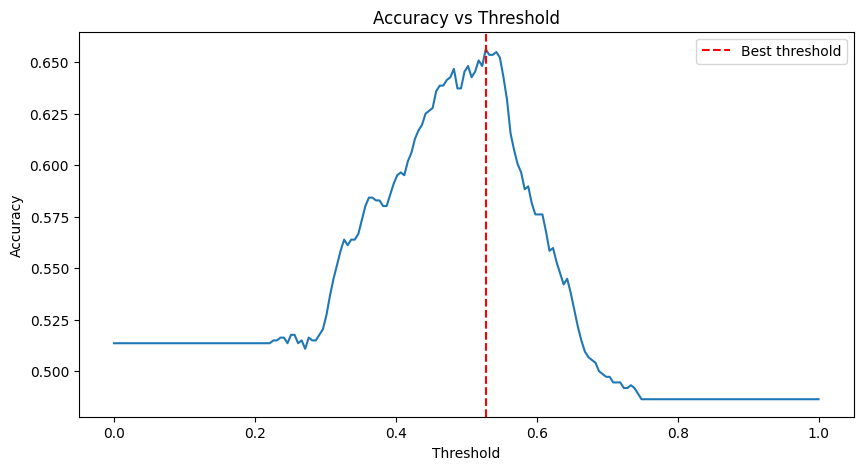

In [905]:
# plot the accuracy vs threshold
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, 200), unseen_accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.axvline(x=unseen_best_thresh_acc, color='r', linestyle='--', label='Best threshold')
plt.legend()
plt.show()

we see a clear bimodel plot of the accuracy as a function of the threshold. This justifies our logic that the borderline cases with model probabilities around 0.5 are hard to classify either way and so we should two seperate thresholds for predicting 0 or 1.

In [906]:
# we use same pickiness as for the test set
# we use same 

pickiness = 1.4

unseen_spreads=data.loc[y_holdout['auction_spread_dir'].index, 'auction_price_spread']

unseen_pred_correctornot = y_holdout['auction_spread_dir'] == unseen_pred_ens_acc
unseen_pred_proba_df=pd.DataFrame(unseen_pred_proba_ens, columns=['predicted_prob'], index=y_holdout['auction_spread_dir'].index)

unseen_thresh_high_proba=unseen_pred_proba_df['predicted_prob'].mean()+pickiness*unseen_pred_proba_df['predicted_prob'].std()
unseen_thresh_low_proba=unseen_pred_proba_df['predicted_prob'].mean()-pickiness*unseen_pred_proba_df['predicted_prob'].std()

unseen_spread_high_proba = unseen_spreads[(unseen_pred_proba_df['predicted_prob'] > unseen_thresh_high_proba) | (unseen_pred_proba_df['predicted_prob'] < unseen_thresh_low_proba)]

print(unseen_pred_correctornot[(unseen_pred_proba_df['predicted_prob'] > unseen_thresh_high_proba) | (unseen_pred_proba_df['predicted_prob'] < unseen_thresh_low_proba)].value_counts(normalize=True))

auction_spread_dir
True     0.713235
False    0.286765
Name: proportion, dtype: float64


In [907]:
print(f"Number of trades: {len(unseen_spread_high_proba)}")
print(f"Proportion of periods with trades: {len(unseen_spread_high_proba)/len(y_holdout)}")

Number of trades: 136
Proportion of periods with trades: 0.18478260869565216


even with the use of picky predictions the accuracy of the model is much worse on unseen data.

## Trading

We trade the test set and the holdout set in order to validate some strategies. We must now consider not just when to trade but also position sizing.